In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython import display

In [2]:
from matplotlib import pyplot as plt
import torch
import bindsnet
import os
import numpy as np
import math

In [3]:
from time import time as t

from bindsnet.datasets import MNIST
from bindsnet.network import Network
from bindsnet.learning import WeightDependentPostPre
from bindsnet.encoding import poisson_loader
from bindsnet.network.monitors import NetworkMonitor
from bindsnet.network.nodes import Input, IFNodes
from bindsnet.network.topology import Connection

### Set Parameters

In [4]:
init_weight_value = 0.8
weights_init_XY = torch.Tensor([[init_weight_value, 1 - init_weight_value],
                                [1 - init_weight_value, init_weight_value]
                               ])

# Learning
### STDP

A_pos = 0.3 # A_+
A_neg = -0.3 # A_-

trace_tc = 1 # 1/tau_+ ; 1/tau_-

# Connections
wmin = 0
wmax = 1
weight_decay = 15e-5

# Neurons
reset = 0.0

#### Thresholds
refrac = 2
thresh = 6.0

# Data encoding
intensity = 200
time = 50

### Plot your STDP curve

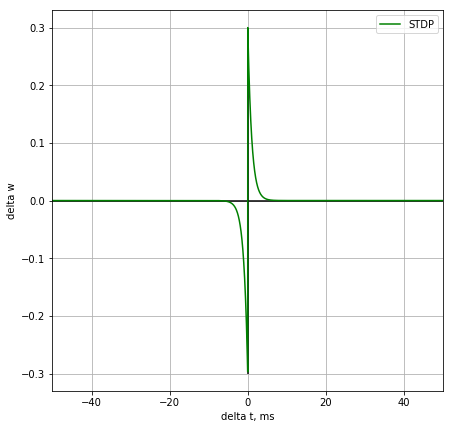

In [5]:
# STDP
delta_t = np.arange(-100, 100, 0.01)
tc_trace_pos = trace_tc
tc_trace_neg = trace_tc
delta_w_STDP = [A_pos * np.exp(-d * tc_trace_pos) if d >= 0 else A_neg * np.exp(d * tc_trace_neg) for d in delta_t]
plt.figure(figsize=(7,7))
plt.plot(delta_t, delta_w_STDP, label='STDP', color='g')
plt.ylabel('delta w')
plt.xlabel('delta t, ms')
plt.vlines(0, A_neg, A_pos)
plt.hlines(0, -100, 100)
plt.legend(loc='best')
plt.xlim(-50, 50)
plt.grid()
plt.show()

### Create Network

In [6]:
network = Network()
input_layer = Input(n=2, 
                    traces=True, 
                    trace_tc=trace_tc
                   )

output_layer = IFNodes(n=2, 
                       traces=True, 
                       thresh=thresh, 
                       reset=reset,
                       refrac=refrac, 
                       trace_tc=trace_tc
                       )

inhibitor_layer = IFNodes(n=2,
                         traces=True,
                         thresh=thresh,
                         reset=reset,
                         refrac=refrac,
                         trace_tc=trace_tc)

conn_XY = Connection(input_layer, 
                     output_layer, 
                     update_rule=WeightDependentPostPre, 
                     w=weights_init_XY, 
                     nu=[A_neg, A_pos], 
                     wmin=wmin, 
                     wmax=wmax,
                     weight_decay=weight_decay
                     )

conn_YH = Connection(output_layer,
                     inhibitor_layer,
                     update_rule=WeightDependentPostPre,
                     w=weights_init_XY,
                     nu=[A_neg, A_pos],
                     wmin=wmin,
                     wmax=wmax,
                     weight_decay=weight_decay,
                     type_of_connection=1
                     )

conn_HY = Connection(inhibitor_layer,
                     output_layer,
                     update_rule=WeightDependentPostPre,
                     w=weights_init_XY,
                     nu=[A_pos, A_neg],
                     wmin=wmin,
                     wmax=wmax,
                     weight_decay=weight_decay,
                     type_of_connection=2
                     )

network.add_layer(input_layer, name='X')
network.add_layer(output_layer, name='Y')
network.add_layer(inhibitor_layer, name='H')

network.add_connection(conn_XY, source='X', target='Y')
network.add_connection(conn_YH, source='Y', target='H')
network.add_connection(conn_HY, source='H', target='Y')

GlobalMonitor = NetworkMonitor(network, state_vars=('v', 's', 'w'))
network.add_monitor(GlobalMonitor, name='Network')

print('GlobalMonitor.state_vars:', GlobalMonitor.state_vars)

GlobalMonitor.state_vars: ('v', 's', 'w')


In [7]:
network.connections[('Y', 'H')].type_of_connection = 1
network.connections[('H', 'Y')].type_of_connection = 2

### Create Custom Dataset

In [8]:
len_dataset = 1000
input_data = torch.zeros(len_dataset, 2)

for i in range(len_dataset):
    if i % 2 == 0:
        input_data[i] = torch.Tensor([1.0, 0.0]) + 0.1*torch.rand([1, 2])
    else:
        input_data[i] = torch.Tensor([0.0, 1.0]) + 0.1*torch.rand([1, 2])
        
input_data *= intensity

# Lazily encode data as Poisson spike trains.
data_loader = poisson_loader(data=input_data, time=time)

# set visualize_sample = True to watch the example
visualize_sample = False

# display.update_display example
if visualize_sample:
    sample = next(data_loader)
    fig = plt.figure(figsize=(4,4))
    for i, sample in enumerate(data_loader):
        if i==0:
            plt.title('spike coding 0 0')
            plt.imshow(sample[0].view(2,1))
            plt.axis('off')
            display.display(fig, display_id = 'spike coding')

        for j, sample_t in enumerate(sample):
            plt.title('spike coding ' + str(i) + ' '+ str(j))
            plt.imshow(sample_t.view(2,1))
            plt.axis('off')
            display.update_display(fig, display_id = 'spike coding')
        print(i)
        
        break

    

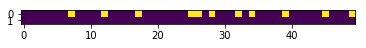

In [9]:
sample = next(data_loader)

# Spike times
plt.figure()
plt.imshow(sample.numpy().T)
plt.show()

### Цикл обучения

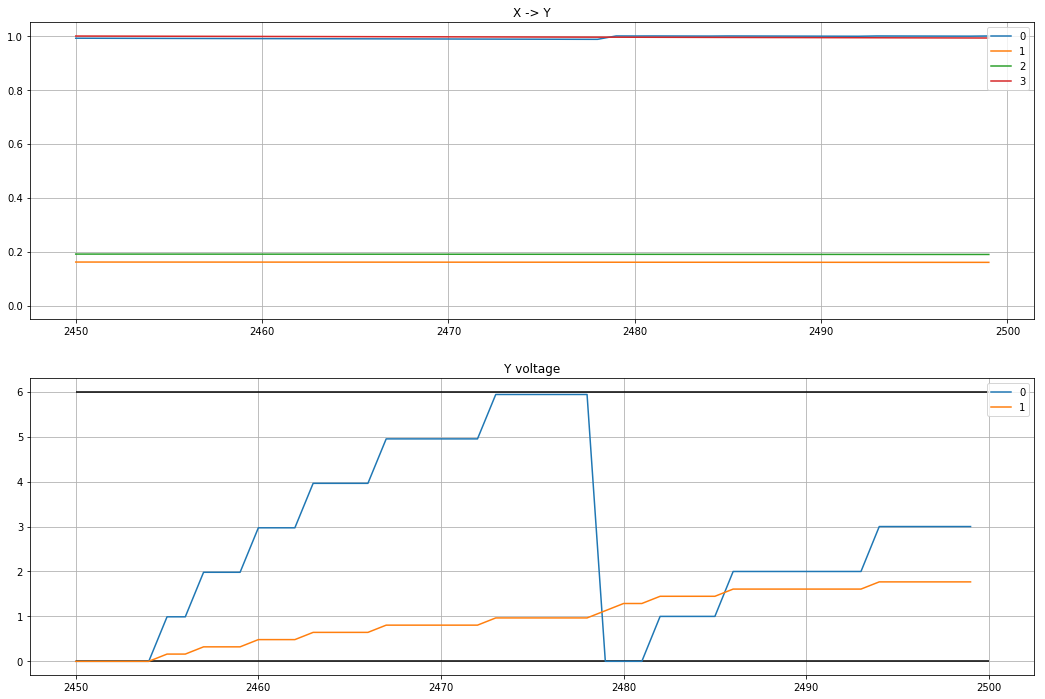

In [10]:
print('Begin training.\n');
start = t()
n_train = 50 # number of training examples
progress_interval = 1 # how often to plot progress

for i in range(n_train):
    if i % progress_interval == 0:
        print('Progress: %d / %d (%.4f seconds)' % (i, n_train, t() - start));
        start = t()

    # Get next input sample.
    sample = next(data_loader)
    inpts = {'X': sample} # set sample to input X

    # Run the network on the input.
    network.run(inpts=inpts, time=time)
    
    # get recordings
    recordings = network.monitors['Network'].get()
    
    # plot   
    # Weights
    fig_w = plt.figure(figsize=(18, 12))
    plt.subplot(2,1,1)
    plt.title('X -> Y')
    weights = recordings[('X', 'Y')]['w'].view(4, -1)
    for j in range(weights.size(0)):
        plt.plot(np.arange(i*weights.size(1), (i+1)*weights.size(1)), weights[j].numpy(), label=str(j))
    plt.legend(loc='upper right')
    plt.ylim(-0.05, 1.05)
    plt.grid()
    
    # Voltages
    plt.subplot(2,1,2)
    plt.title('Y voltage')
    voltages = recordings[('Y')]['v'].view(2, -1)
    for j in range(voltages.size(0)):
        plt.plot(np.arange(i*voltages.size(1), (i+1)*voltages.size(1)), voltages[j].numpy(), label=str(j))
    plt.legend(loc='upper right')
    plt.hlines([reset, thresh], i*voltages.size(1), (i+1)*voltages.size(1))
    plt.grid()
    
    display.clear_output(wait=True)
    display.display(fig_w, display_id = 'weights')
    
    network.reset_()  # Reset state variables
    
    plt.close(fig_w)

In [11]:
network.connections[('X', 'Y')].w.numpy()

array([[1.        , 0.16008481],
       [0.18939257, 0.99237853]], dtype=float32)

In [12]:
network.connections[('Y', 'H')].w.numpy()

array([[0.54981554, 0.13745388],
       [0.13745388, 0.54981554]], dtype=float32)

In [14]:
network.connections[('H', 'Y')].w.numpy()

array([[0.54981554, 0.13745388],
       [0.13745388, 0.54981554]], dtype=float32)